# Uncertainty-Aware Road Obstacle Identification (UAROI)

---

**Final Project and Exam $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ Computer Vision | Sapienza Università di Roma**

---

* Jose Edgar Hernandez Cancino Estrada | 2223606
* Marcelo Jimenez Da Fonseca | 2224588
* Enrique Favila Martinez | 2223610

## Conformal Risk Control and Unknown Object Score Evaluation

In this notebook, the **LostAndFound** dataset is used to evaluate a model's ability to detect small, unexpected obstacles on the road—especially those not seen during training (out-of-distribution or OOD). This dataset is designed to test the robustness of perception systems for self-driving vehicles in challenging scenarios involving rare or unknown objects.

The dataset consists of high-resolution stereo images with pixel-wise segmentation labels indicating various types of road hazards (e.g., lost cargo, small road debris) as well as background classes like road and sidewalk.

In our setup:
- The model is **trained on Cityscapes**, which does not contain these small hazards.
- The **LostAndFound dataset is used exclusively for evaluation**, providing a realistic benchmark for unknown object detection.

Unknown Objectness Scores are calculated for each pixel, and Conformal Risk Control is applied to find a binarization threshold that provides a statistical guarantee on the False Negative rate.

Three models with different weights are evaluated to determine the best.

Epoch 8 is the best result from the first training using a Non boundary aware cross binary entropy loss function, and epoch 11 and 12 are the best results from the new training with Boundary aware loss function.


---

**References**

- Pinggera, P., Ramos, S., Gehrig, S., Franke, U., Rother, C., & Mester, R. (2016). *Lost and found: Detecting small road hazards for self-driving vehicles*. In *2016 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS)*, pp. 1099–1106. IEEE. [https://doi.org/10.1109/IROS.2016.7759183](https://doi.org/10.1109/IROS.2016.7759183)

- Sakaridis, C., Dai, D., & Van Gool, L. (2019). *Road Obstacle Detection based on Unknown Objectness Scores*. [https://arxiv.org/abs/1905.07477](https://arxiv.org/abs/1905.07477)

# Imports

In [3]:
# Imports
import os
import torch
import tarfile
import torch.nn as nn
import numpy as np
import pathlib,zipfile
from tqdm import tqdm

from google.colab import drive
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

from scipy.optimize import brentq
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

#Downloads

In [2]:
# !pip install --upgrade gdown
!gdown --folder https://drive.google.com/drive/folders/1-VEDc9kRDWo2pcsmBJnefwZEcV4qkNk7 -O dataset
!gdown --folder https://drive.google.com/drive/folders/1X_sie38bSouwjZVhEQQuzjMd5YJ0Lht9 -O dataset

Retrieving folder contents
Processing file 1O-hPsO0EnpwGyxtARgV435qrlEsYBE9O Archive.zip
Processing file 17DHauTnh_2kYZQfAzvKzLM48unh-6cOM epoch_8.pth
Processing file 1g0RE2SfC54ML6_ij31ROYgxaRNjSjkDx laf_test.tar.gz
Processing file 1gs462TizSbLJfDC8d4MNCz2Joa_CfPH8 laf_train.tar.gz
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1O-hPsO0EnpwGyxtARgV435qrlEsYBE9O
From (redirected): https://drive.google.com/uc?id=1O-hPsO0EnpwGyxtARgV435qrlEsYBE9O&confirm=t&uuid=1892674e-8c55-451e-869d-d8b36e72b582
To: /content/dataset/Archive.zip
100% 2.03G/2.03G [01:25<00:00, 23.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=17DHauTnh_2kYZQfAzvKzLM48unh-6cOM
From (redirected): https://drive.google.com/uc?id=17DHauTnh_2kYZQfAzvKzLM48unh-6cOM&confirm=t&uuid=a4588009-0aa7-4ed2-903d-fefef4a5b53a
To: /content/dataset/epoch_8.pth
100% 157M/157M [00:09<00:00, 16.5MB/s]

In [4]:
# Config

extract_dir     = '/content/laf_data'
model_weights = [ '/content/dataset/epoch_8_non_boundary_aware.pth',
                 '/content/dataset/epoch_11_boundary_aware.pth',
                  '/content/dataset/epoch_12_boundary_aware.pth']
train_laf_path  = '/content/dataset/laf_train.tar.gz'
test_laf_path   = '/content/dataset/laf_test.tar.gz'

LOCAL_PATH = "/content/dataset"

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) device")
else:
    device = torch.device("cpu")
    print("Using CPU")

DEVICE = device

Using CUDA device: NVIDIA L4


In [4]:
# Execute
os.makedirs(extract_dir, exist_ok=True)
with tarfile.open(train_laf_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)
with tarfile.open(test_laf_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)

# Utils

## LostAndFound Dataset utils



In [5]:
class LostAndFound(Dataset):
    def __init__(self, folder, binarize=False, device='cuda'):
        self.files = sorted([
            os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.pt')
        ])
        self.binarize = binarize
        self.device = device

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        image = data['image'].permute(2, 0, 1).float() / 255.0  # [3, H, W]
        mask = data['mask'].float()                            # [H, W]

        if self.binarize:
            mask = (mask > 1).float()  # Anything > 1 → 1, else 0

        mask = mask.unsqueeze(0)  # [1, H, W]
        return image.to(self.device), mask.to(self.device)

    def visualize(self, idx):
      image, mask = self[idx]
      image_np = image.permute(1, 2, 0).cpu().numpy()
      mask_np = mask.squeeze().cpu().numpy()

      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.imshow(image_np)
      plt.title("Original Image")
      plt.axis("off")

      plt.subplot(1, 2, 2)
      plt.imshow(image_np * 0.8)
      plt.imshow(mask_np, alpha=0.65, cmap='plasma')
      plt.title("Segmentation Mask")
      plt.axis("off")

      plt.show()

    def visualize_uos(self, idx, unkown_obj_score, unknown_score, objectness_score):
      image, mask = self[idx]
      image_np = image.permute(1, 2, 0).cpu().numpy()
      mask_np = mask.squeeze().cpu().numpy()
      uos_np = unkown_obj_score.cpu().numpy()
      unknown_class_score_np = unknown_score.cpu().numpy()
      objectness_score_np = objectness_score.cpu().numpy()

      fig, axs = plt.subplots(1, 4, figsize=(22, 6))
      titles = [
          "Segmentation Mask",
          "Objectness Class Prediction",
          "Unknown Class Score",
          "Unknown Object Score"
      ]

      # 1. Segmentation Mask (stronger alpha on object pixels)
      axs[0].imshow(image_np * 0.8)
      axs[0].imshow(mask_np, alpha=0.42, cmap='plasma')
      axs[0].set_title(titles[0], fontsize=16)
      axs[0].axis("off")

      # 2. Objectness Score
      axs[1].imshow(image_np * 0.8)
      axs[1].imshow(objectness_score_np, alpha=0.65, cmap='plasma')
      axs[1].set_title(titles[1], fontsize=16)
      axs[1].axis("off")

      # 3. Unknown Class Score
      axs[2].imshow(image_np * 0.8)
      im_unk_class = axs[2].imshow(unknown_class_score_np, cmap='hot', alpha=0.8)
      axs[2].set_title(titles[2], fontsize=16)
      axs[2].axis("off")
      cbar1 = fig.colorbar(im_unk_class, ax=axs[2], fraction=0.046, pad=0.02)
      cbar1.ax.tick_params(labelsize=10)

      # 4. Unknown Object Score (UOS)
      axs[3].imshow(image_np * 0.8)
      im_uos = axs[3].imshow(uos_np, cmap='hot', alpha=0.8)
      axs[3].set_title(titles[3], fontsize=16)
      axs[3].axis("off")
      cbar2 = fig.colorbar(im_uos, ax=axs[3], fraction=0.046, pad=0.02)
      cbar2.ax.tick_params(labelsize=10)

      plt.tight_layout()
      plt.show()

    def visualize_uos_threshold(self,rgb_image, unk_obj_score, gt_mask, threshold=0.5):
      """
      Args:
      rgb_image (Tensor): [3, H, W] image
      unk_obj_score (Tensor): [H, W] float tensor (values 0-1)
      gt_mask (Tensor): [H, W] binary mask
      threshold (float): Threshold to binarize the score
      """
      fig, axs = plt.subplots(1, 4, figsize=(16, 4))
      # 1. Original RGB image
      axs[0].imshow(rgb_image.permute(1, 2, 0).cpu().numpy())
      axs[0].set_title("RGB Image")
      axs[0].axis("off")

      # 2. Unknown object score (heatmap)
      im1 = axs[1].imshow(unk_obj_score.cpu(), cmap='inferno', vmin=0, vmax=1)
      axs[1].set_title("Unk. Object Score")
      axs[1].axis("off")
      fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.02)

      # 3. Binary prediction (thresholded)
      axs[2].imshow((unk_obj_score > threshold).cpu(), cmap='gray')
      axs[2].set_title(f"Unk Object Score > {threshold}")
      axs[2].axis("off")

      # 4.Ground truth mask
      axs[3].imshow(gt_mask.cpu(), cmap='gray')
      axs[3].set_title("Ground Truth Mask")
      axs[3].axis("off")

      plt.tight_layout()
      plt.show()



## Conformal Risk Control Utils

In [6]:
class ConformalRiskControl:
    def __init__(self, pred_scores, gt_masks, alpha=0.1, batch_size = 32):
        assert pred_scores.shape == gt_masks.shape, \
              f"Shape mismatch: pred_scores {pred_scores.shape} vs gt_mask {gt_mask.shape}"

        self.alpha = alpha  # user-defined acceptable risk level
        self.lamhat = None  # calibrated threshold, to be computed later
        self.pred_scores = pred_scores
        self.gt_masks = gt_masks
        self.num_samples = pred_scores.shape[0]
        self.batch_size = batch_size

    def false_negative_rate_batched(self,threshold):
        """
        Computes the average False Negative Rate (FNR) over a dataset in batches,
        skipping samples where the ground truth has no positives.
        """
        fnr_values = []
        for start_idx in range(0, self.num_samples, self.batch_size):
            end_idx = start_idx + self.batch_size
            # Binarize predictions using threshold
            binary_predictions = (self.pred_scores[start_idx:end_idx] >= threshold).astype(np.float32)
            # Get ground truth batch
            gt_batch = self.gt_masks[start_idx:end_idx].astype(np.float32)
            # Compute per-sample counts
            true_positives = (binary_predictions * gt_batch).sum(axis=(1, 2))
            total_positives = gt_batch.sum(axis=(1, 2))
            for tp, total in zip(true_positives.tolist(), total_positives.tolist()):
                if total == 0:
                    # print("⚠️ Warning: Skipping sample with no positives in ground truth.")
                    continue  # Skip this sample
                recall = tp / total
                fnr = 1.0 - recall
                fnr_values.append(fnr)
            # free ram memory
            del binary_predictions, gt_batch, true_positives, total_positives
        if len(fnr_values) == 0:
            raise ValueError("All samples had empty ground truth masks. FNR cannot be computed.")
        return np.mean(fnr_values)


    def lamhat_threshold(self, lam):
        """
        The root of this equation corresponds to the highest threshold λ̂  such that
        the empirical False Negative Rate (FNR) is below the conformal risk bound.
        Alpha is transform to a conformal upper bound so the bound is guaranteed to
        hold with higher probability.
        """
        conformal_bound = (self.num_samples+1)/self.num_samples * alpha - 1/self.num_samples
        return self.false_negative_rate_batched(lam) - conformal_bound


    def calibrate(self):
        """
        Finds the optimal threshold λ̂ using Brent's method such that the
        empirical FNR is below the conformal bound with high confidence.
        """

        self.lamhat = brentq(self.lamhat_threshold, 0, 1)
        fnr = self.false_negative_rate_batched(self.lamhat)
        print(f"Calibrated threshold λ̂ = {self.lamhat:.4f} " )
        print(f"mean FNR in Calibration Dataset = {fnr:.4f}")
        print(f"FNR bound = {self.alpha:.4f}")
        return self.lamhat

    def false_negative_rate(self,pred_masks, true_masks):
        return 1-((pred_masks * true_masks).sum()/true_masks.sum())



## Model utils

In [7]:
class DeepLabV3_SigmoidHead(nn.Module):
    def __init__(self, num_classes,  weights_path=None):
        super().__init__()
        self.num_classes = num_classes

        # Load pretrained DeepLabV3
        if weights_path and os.path.exists(weights_path):
            backbone = deeplabv3_resnet50(weights=None)
        else:
            backbone = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)

        # Remove the classifier
        self.backbone_features = backbone.backbone
        self.aspp = backbone.classifier[0]  # ASPP module
        # Custom sigmoid head
        self.classifier = nn.Sequential(nn.Dropout(0.5),
                                        nn.Conv2d(256, num_classes + 1, kernel_size=1),
                                        # nn.Sigmoid() # RIGHT NOW IT IS COMMENTED AS WE WILL TRAIN USING torch.nn.BCEWithLogitsLoss
                                        )
        if weights_path:
            self.load_weights(weights_path)

    def forward(self, x):
        input_shape = x.shape[-2:]
        # Extract features
        features = self.backbone_features(x)
        # Apply ASPP
        x = self.aspp(features['out'])
        # Apply classifier with sigmoid
        x = self.classifier(x)
        # Upsample to input resolution
        x = nn.functional.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x

    def load_weights(self, path):
      if not os.path.exists(path):
          print("No model weights found at:", path)

      # Load the state dictionary directly from the file
      state_dict = torch.load(path)
      self.load_state_dict(state_dict)

    def save_weights(self, path):
      torch.save(self.state_dict(), path)

    def single_unknown_obj_score(self, image, uos_only = True):
      self.eval()
      with torch.no_grad():
        input_tensor = image.unsqueeze(0)  # [1,3,H,W]
        output = self(input_tensor)                 # [1,num_classes (8),H,W]
        pred_mask = torch.sigmoid(output).squeeze(0).cpu()  # [num_classes (8),H,W] -> Dimension 0 will contain predictions for each of the num_classes classes

        # Get the unknown scores (1 - product_{k=1}^{K} (1 - p_{ik})) for each pixel i
        known_class_probs = pred_mask[:7,:,:] # Shape: [7, H, W]
        inv_known_class_probs = 1 - known_class_probs
        unknown_score = torch.prod(inv_known_class_probs, dim=0) # Shape: [H, W]

        objectness_score = pred_mask[7,:,:] # Shape: [H, W]
        unkown_obj_score = unknown_score * objectness_score # Pixel-Wise | Shape: [H, W]

        if uos_only:
          return unkown_obj_score
        else:
          return unkown_obj_score, unknown_score, objectness_score, pred_mask

    def unknown_obj_scores(self, dataset):
      self.eval()
      all_gt_mask = []
      all_unk_obj_score = []
      for idx in tqdm(range(len(dataset)),desc="Computing UOS"):
        image, mask = dataset[idx]
        unknown_obj_score = self.single_unknown_obj_score(image, uos_only=True)
        all_unk_obj_score.append(unknown_obj_score)
        all_gt_mask.append(mask)

      return torch.stack(all_unk_obj_score, dim=0), torch.stack(all_gt_mask, dim=0).squeeze(1)



# Dataset

Original training dataset size: 1036
Original test dataset size: 1203
Calibration dataset size: 500
Evaluation dataset size: 86


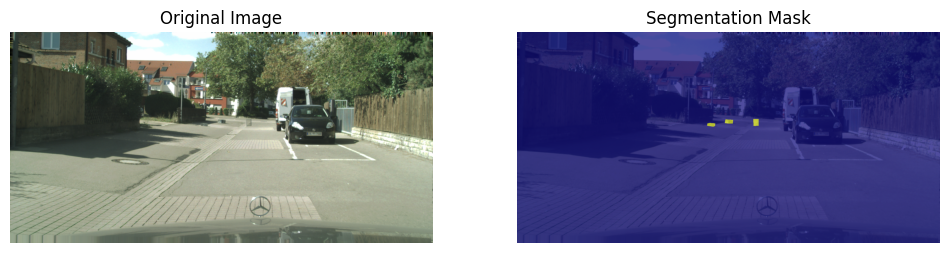

Image shape: torch.Size([3, 1024, 2048])
Mask shape: torch.Size([1, 1024, 2048])


In [8]:
# Define the size of the calibration set
calibration_size = 500
dataset_train = LostAndFound('/content/laf_data/laf_train', binarize=True, device=str(DEVICE))
dataset_test = LostAndFound('/content/laf_data/laf_test', binarize=True, device=str(DEVICE))
print(f"Original training dataset size: {len(dataset_train)}")
print(f"Original test dataset size: {len(dataset_test)}")

# Calculate the size of the remaining training set
train_size_after_calibration = len(dataset_train) - calibration_size
dataset_calibration = torch.utils.data.Subset(dataset_train, list(range(calibration_size)))
dataset_evaluation= torch.utils.data.Subset(dataset_train, list(range(calibration_size+450, len(dataset_train))))


print(f"Calibration dataset size: {len(dataset_calibration)}")
print(f"Evaluation dataset size: {len(dataset_evaluation)}")


train_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=4)
test_loader  = DataLoader(dataset_test, batch_size=4, shuffle=False, num_workers=4)

idx = 199
dataset_test.visualize(idx)

img, mask = dataset_test[idx]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

# Model

In [10]:
""" MODEL DEFINITION
  Create model for Cityscapes with 7 grouped classes + objectness
  As mentioned in the paper:
  1. "road"
  2. "flat(w/o road)"
  3. "human"
  4. "vehicle"
  5. "construction"
  6. "object"
  7. "background"

"""

model_e8  = DeepLabV3_SigmoidHead(num_classes=7, weights_path=model_weights[0])
model_e11 = DeepLabV3_SigmoidHead(num_classes=7, weights_path=model_weights[1])
model_e12 = DeepLabV3_SigmoidHead(num_classes=7, weights_path=model_weights[2])
model_e8  = model_e8.to(DEVICE)
model_e11 = model_e11.to(DEVICE)
model_e12 = model_e12.to(DEVICE)

# Unknown Objectness Score (UOS)

Random Indices: [391, 525]


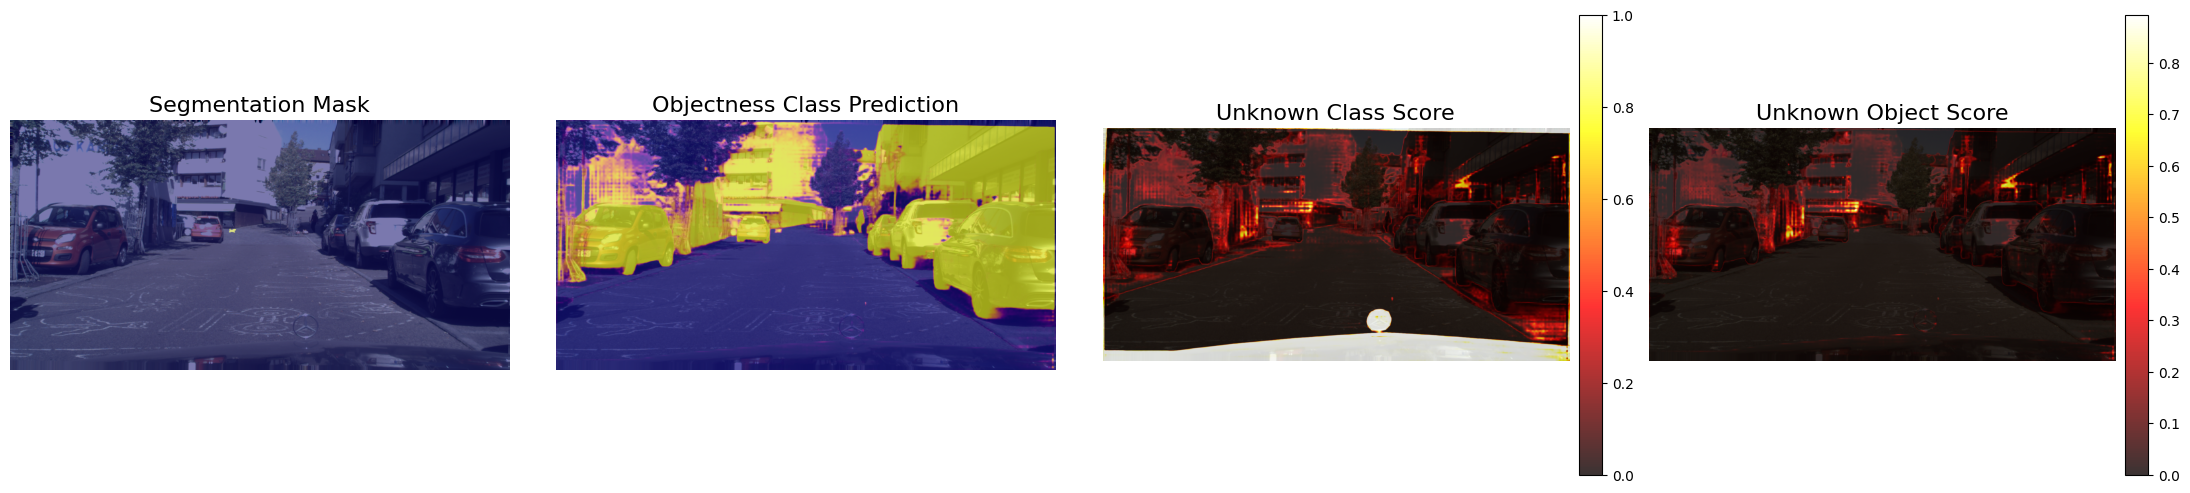

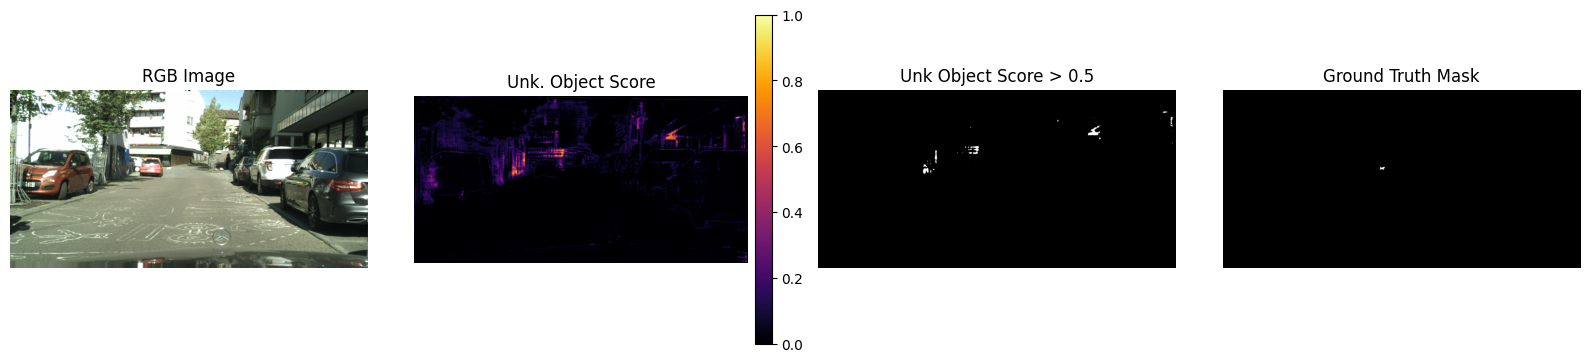

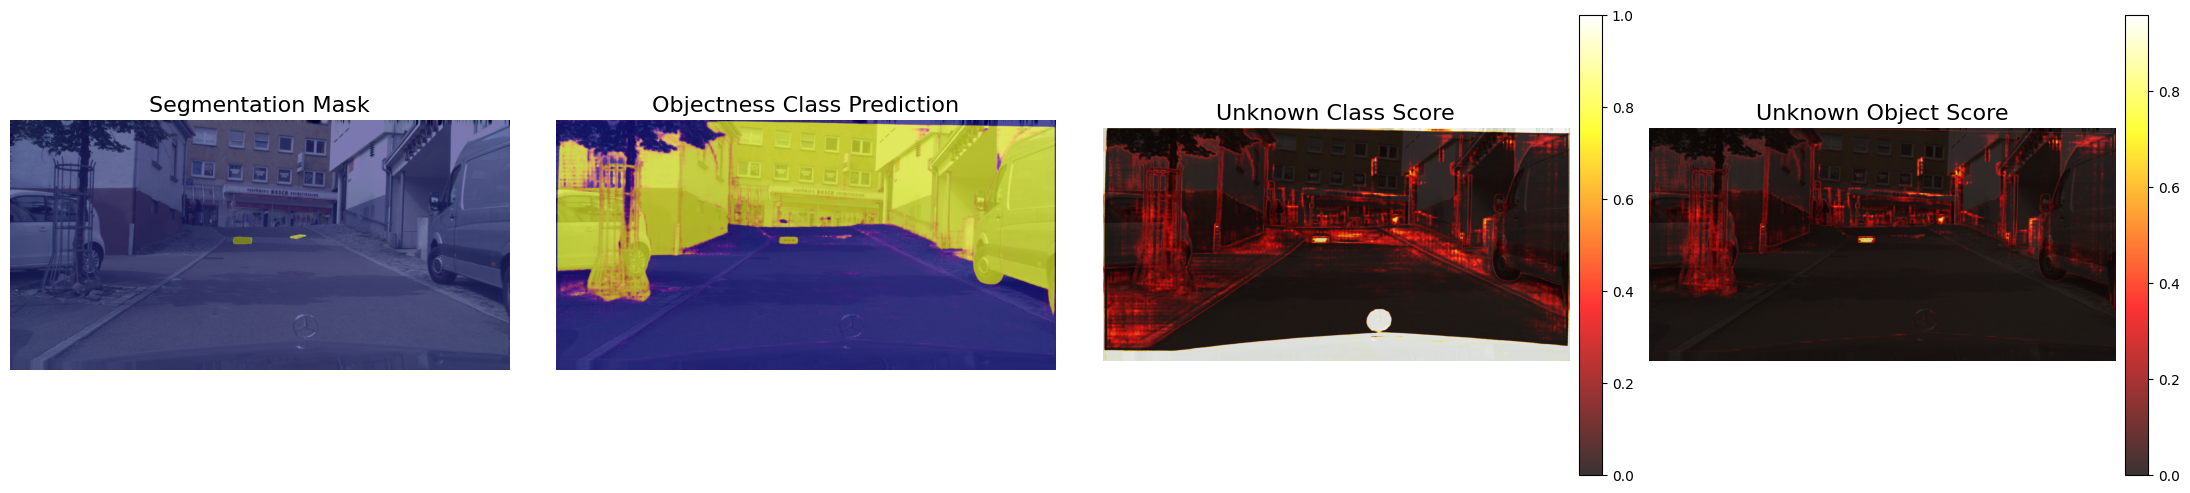

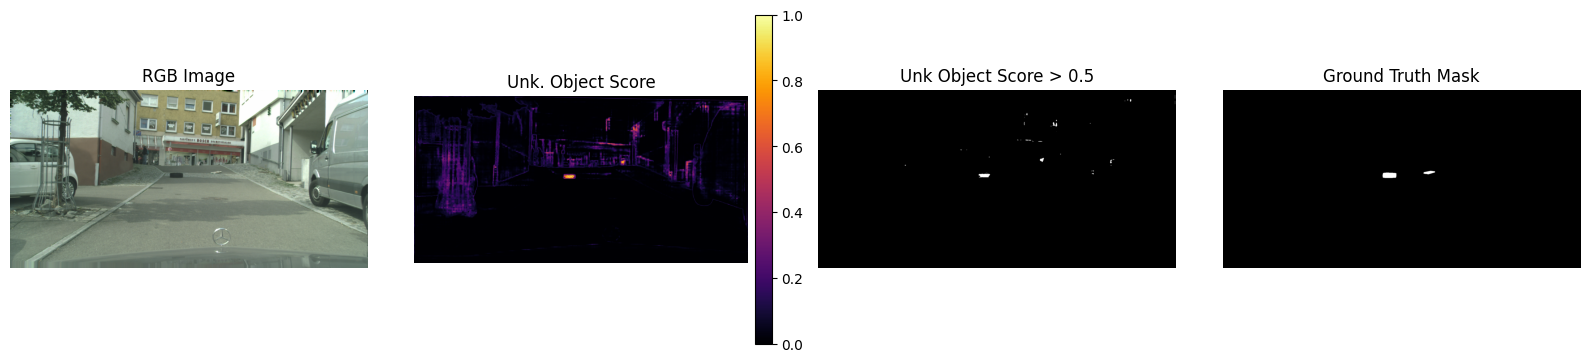

In [26]:
#@title Random Sample Visualization
df = dataset_test

import random
indices = random.sample(range(len(dataset_test)), 2)
print(f"Random Indices: {indices}")


for idx in indices:
  image, gt_mask = df[idx]
  unknown_obj_score, unknown_score, objectness_score, pred_mask = model_e11.single_unknown_obj_score(image, uos_only=False)
  df.visualize_uos(idx, unknown_obj_score, unknown_score, objectness_score)
  # print("Using threshold = 0.5 for binarization.")
  df.visualize_uos_threshold(image, unknown_obj_score, gt_mask.squeeze(0))


#Conformal Risk Control Calibration using LostAndFound training set

In this section, we implement **Conformal Risk Control (CRC)** to determine a statistically valid threshold for binarizing the Unknown Objectness Score (UOS). Instead of selecting a fixed threshold arbitrarily or by trial-and-error, CRC provides a principled way to choose a threshold that guarantees a bound on the **False Negative Rate (FNR)**.

The main idea is:
- Compute UOS for each pixel in a **calibration set**.
- Compare these scores to the ground truth mask to measure false negative rate (our calibration loss function)
- Use the conformal prediction framework to select a threshold `λ̂` such that the **expected FNR is below a user-defined level `α`** (e.g., 10%).

We solve this using brentq numerical method to find the largest threshold `λ̂` such that the empirical risk stays within the desired bound.

In [14]:
#@title Unknown object scores of Calibration Set for each model

#If problems with RAM, uncomment to save in independent files the calibration

uos_cal_8, gt_masks = model_e8.unknown_obj_scores(dataset_calibration)
# # Convert torch tensor to numpy and save it as file (RAM usage precautions)
# print("Saving UOS and GT to files ...")
# np.savez_compressed("unk_obj_scores_e8.npz", uos=unk_obj_scores.cpu().numpy())
# np.savez_compressed("gt_mask_uos.npz",  gt = gt_masks.cpu().numpy())
# del uos_cal_8
# del gt_masks

uos_cal_12, gt_masks = model_e12.unknown_obj_scores(dataset_calibration)
# # Convert torch tensor to numpy and save it as file (RAM usage precautions)
# print("Saving UOS to file ...")
# np.savez_compressed("unk_obj_scores_e12.npz", uos=unk_obj_scores.cpu().numpy())
# del uos_cal_12
# del gt_masks

uos_cal_11, gt_masks = model_e11.unknown_obj_scores(dataset_calibration)
# # Convert torch tensor to numpy and save it as file (RAM usage precautions)
# print("Saving UOS to file ...")
# np.savez_compressed("unk_obj_scores_e11.npz", uos=unk_obj_scores.cpu().numpy())
# print(f"Unknown Object Score Shape: {unk_obj_scores.shape}")
# print(f"Ground Truth Mask Shape: {gt_masks.shape}")
# # del uos_cal_11
# # del gt_masks

Computing UOS: 100%|██████████| 500/500 [01:57<00:00,  4.27it/s]


In [94]:
#@title Choosing alpha
alpha = 0.9 # alpha is the maximun tolerated false negative rate

Intuitively, with alpha =10% we can state that:

> “On average, across images in the test set, I want the proportion of ground-truth positive (obstacle) pixels that are missed (i.e., predicted as negative) to be no more than 10%.”

> For a pixel that should be labeled "obstacle", there’s at most a 10% chance (on average) that the model will miss it.

In [97]:
#@title Import Unknown Object Scores (Choose the model)
# import numpy as np
# uos_e8 = np.load('unk_obj_scores_e8.npz')['uos']
# gt_masks = np.load('gt_mask_uos.npz')['gt']


CRC_e8 = ConformalRiskControl(uos_cal_8.cpu().numpy(),gt_masks.cpu().numpy(),alpha)

In [98]:
#@title Conformal Risk Control Calibration
lamhat_8 = CRC_e8.calibrate()

Calibrated threshold λ̂ = 0.2222 
mean FNR in Calibration Dataset = 0.8998
FNR bound = 0.9000


Random Indices: [872, 228]


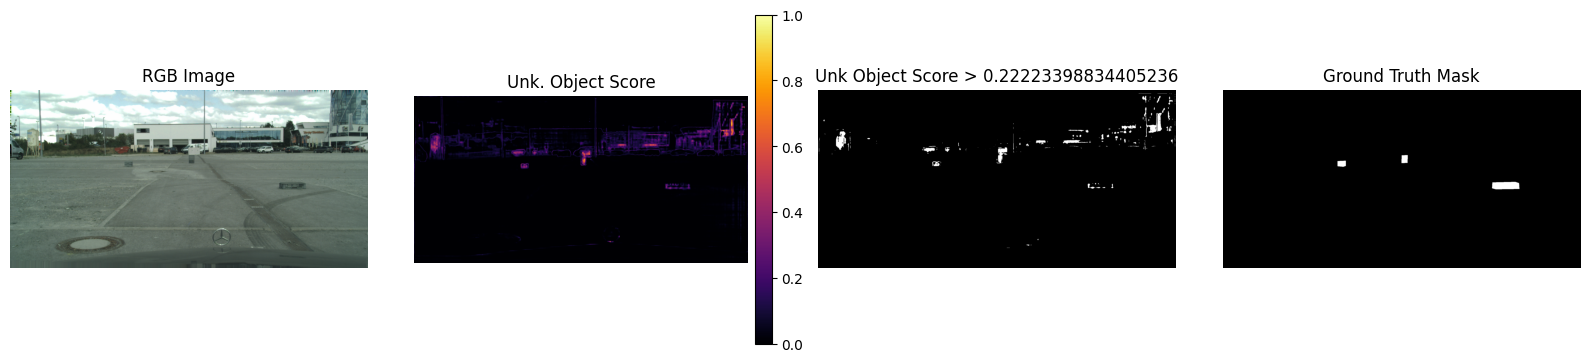

False Negative rate: 0.7316811084747314, should be less than alpha = 0.9


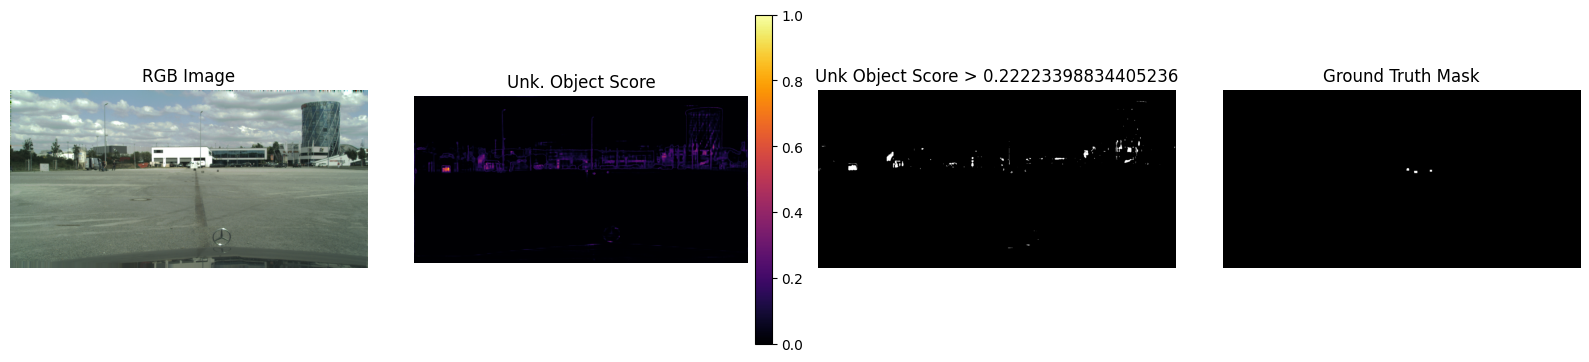

False Negative rate: 0.748275876045227, should be less than alpha = 0.9


In [99]:
#@title Threshold visualization
df = dataset_test

import random
indices = random.sample(range(len(dataset_test)), 2)
print(f"Random Indices: {indices}")

for idx in indices:
  image, gt_mask = df[idx]

  gt_mask = gt_mask.squeeze(0).cpu()
  unknown_obj_score, unknown_score, objectness_score, pred_mask = model_e8.single_unknown_obj_score(image, uos_only=False)
  df.visualize_uos_threshold(image, unknown_obj_score, gt_mask,lamhat_8)
  fnr = CRC_e8.false_negative_rate((unknown_obj_score.cpu()>lamhat_8).float(), gt_mask)
  print(f"False Negative rate on image is : {fnr.item()}, should be less than alpha = {alpha}")

# Unknown Object Score Evaluation using LostAndFound Test Set

In [ ]:
#free space in RAM
del uos_cal_8,uos_cal_11, uos_cal_12, gt_masks

In [11]:
#If problems with RAM, uncomment to save in independent files the calibration

uos_test_8, gt_masks = model_e8.unknown_obj_scores(dataset_evaluation)
# Convert torch tensor to numpy and save it as file (RAM usage precautions)
# print("Saving UOS and GT to files ...")
# np.savez_compressed("uos_test_8.npz", uos=uos_test_8.cpu().numpy())
# np.savez_compressed("gt_mask_uos.npz",  gt = gt_masks.cpu().numpy())
# del unk_obj_scores
# del gt_masks

# uos_test_11, gt_masks = model_e11.unknown_obj_scores(dataset_test)
# # Convert torch tensor to numpy and save it as file (RAM usage precautions)
# print("Saving UOS to file ...")
# np.savez_compressed("unk_obj_scores_e11.npz", uos=unk_obj_scores.cpu().numpy())
# del unk_obj_scores
# del gt_masks

# uos_test_12, gt_masks = model_e12.unknown_obj_scores(dataset_test)
# # Convert torch tensor to numpy and save it as file (RAM usage precautions)
# print("Saving UOS to file ...")
# np.savez_compressed("unk_obj_scores_e12.npz", uos=unk_obj_scores.cpu().numpy())

# print(f"Unknown Object Score Shape: {unk_obj_scores.shape}")
# print(f"Ground Truth Mask Shape: {gt_masks.shape}")

# del unk_obj_scores
# del gt_masks


Computing UOS: 100%|██████████| 86/86 [00:27<00:00,  3.08it/s]


In [ ]:
import numpy as np
uos_e8 = np.load('uos_test_8.npz')['uos']
gt_masks = np.load('gt_mask_uos.npz')['gt']

In [12]:
from sklearn.metrics import roc_curve
def fpr_at_95_tpr(y_true, y_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    # Find the first index where TPR >= 0.95
    idx = np.searchsorted(tpr, 0.95)
    return fpr[idx] if idx < len(fpr) else 1.0

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import gc
def evaluate_model_scores(gt_mask_tensor, score_tensor, plot=True, name="Model"):
    """
    Evaluate binary segmentation scores using ROC AUC, Average Precision,
    and FPR@95%TPR metrics. Optionally plots ROC and PR curves.

    Args:
        gt_mask_tensor (torch.Tensor): Binary ground truth mask (0 and 1).
        score_tensor (torch.Tensor): Continuous prediction scores (e.g., UOS).
        plot (bool): If True, shows ROC and PR plots.
        name (str): Name used in plot titles and labels.

    Returns:
        dict: Dictionary containing 'roc_auc', 'ap', and 'fpr95'.
    """
    y_true = gt_mask_tensor.cpu().numpy().flatten().astype(np.uint8)
    y_score = score_tensor.cpu().numpy().flatten().astype(np.float16)

    # ROC
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)

    # FPR at 95% TPR
    fpr95 = fpr_at_95_tpr(y_true, y_score)

    if plot:
        # ROC Plot
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, label=f"{name} ROC (AUC = {roc_auc:.3f})", color="darkorange", lw=2)
        plt.plot([0, 1], [0, 1], "k--", lw=1.5, label="Random Guess")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # PR Plot
        plt.figure(figsize=(7, 6))
        plt.plot(recall, precision, label=f"{name} PR (AP = {ap:.3f})", color="green", lw=2)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision–Recall Curve")
        plt.legend(loc="lower left")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Verbal Summary
    print(f"[{name}] Area Under the ROC Curve (AUC): {roc_auc:.4f}")
    print(f"[{name}] Average Precision (AP): {ap:.4f}")
    print(f"[{name}] FPR @ 95% TPR: {fpr95*100:.2f}%")
    print(f"When the model identifies obstacle pixels, only about {ap*100:.2f}% are correct.")
    print(f"That means {100 - ap*100:.2f}% of predicted obstacles are false positives.")
    print(f"When the model recalls 95% of obstacles, it also misclassifies {fpr95*100:.2f}% of background as obstacles.")

    # Free memory
    del y_true, y_score
    gc.collect()
    torch.cuda.empty_cache()

    return {
        "roc_auc": roc_auc,
        "average_precision": ap,
        "fpr95": fpr95
    }

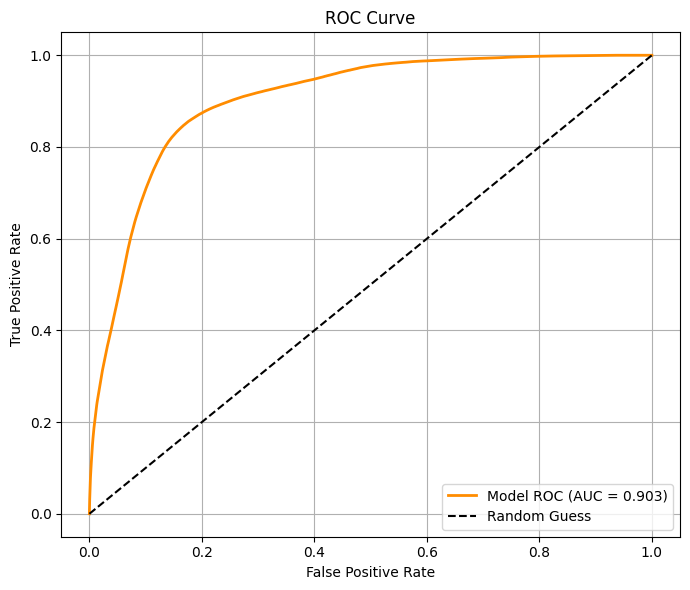

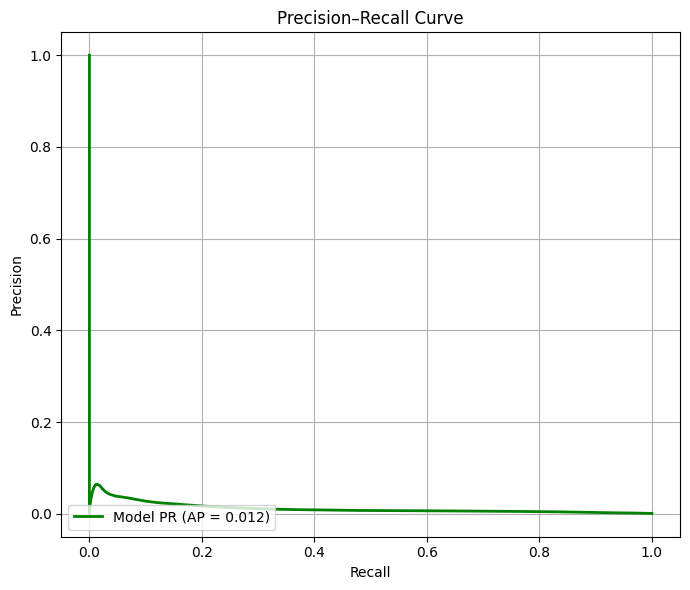

[Model] Area Under the ROC Curve (AUC): 0.9032
[Model] Average Precision (AP): 0.0117
[Model] FPR @ 95% TPR: 40.66%
When the model identifies obstacle pixels, only about 1.17% are correct.
That means 98.83% of predicted obstacles are false positives.
When the model recalls 95% of obstacles, it also misclassifies 40.66% of background as obstacles.


{'roc_auc': np.float64(0.9032162660005707),
 'average_precision': np.float64(0.011733338099654616),
 'fpr95': np.float64(0.40657080824150393)}

In [14]:
evaluate_model_scores(gt_masks,uos_test_8,"Epoch 8 Non Boundary Aware")

In [17]:
import gc
def evaluate_model_scores_batched(gt_mask_tensor, score_tensor, batch_size=8, plot=True, name="Model"):
    """
    Efficiently evaluates ROC AUC, AP, and FPR@95TPR over large datasets using internal batching.

    Args:
        gt_mask_tensor (torch.Tensor): [B, H, W] or list of tensors
        score_tensor (torch.Tensor): [B, H, W] or list of tensors
        batch_size (int): Batch size to use internally
        plot (bool): Whether to plot ROC and PR curves
        name (str): Name used in print/logging output

    Returns:
        dict with keys 'roc_auc', 'average_precision', 'fpr95'
    """
    y_true_all = []
    y_score_all = []

    N = gt_mask_tensor.shape[0]
    for i in range(0, N, batch_size):
        gt_batch = gt_mask_tensor[i:i+batch_size]
        score_batch = score_tensor[i:i+batch_size]

        # Flatten and store as low-precision numpy
        gt_np = gt_batch.cpu().numpy().astype(np.uint8).reshape(-1)
        score_np = score_batch.cpu().numpy().astype(np.float16).reshape(-1)

        y_true_all.append(gt_np)
        y_score_all.append(score_np)

        del gt_batch, score_batch, gt_np, score_np
        gc.collect()
        torch.cuda.empty_cache()

    # Concatenate all batched results
    y_true = np.concatenate(y_true_all)
    y_score = np.concatenate(y_score_all)

    # Compute metrics
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = roc_auc_score(y_true, y_score)
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    fpr95 = fpr_at_95_tpr(y_true, y_score)

   # Plots (side by side)
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))

        # ROC Curve
        axs[0].plot(fpr, tpr, label=f"ROC (AUC = {roc_auc:.3f})", color="darkorange", lw=2)
        axs[0].plot([0, 1], [0, 1], "k--", lw=1.5)
        axs[0].set_xlabel("False Positive Rate")
        axs[0].set_ylabel("True Positive Rate")
        axs[0].set_title("ROC Curve")
        axs[0].legend(loc="lower right")
        axs[0].grid(True)

        # PR Curve
        axs[1].plot(recall, precision, label=f"PR (AP = {ap:.3f})", color="green", lw=2)
        axs[1].set_xlabel("Recall")
        axs[1].set_ylabel("Precision")
        axs[1].set_title("Precision–Recall Curve")
        axs[1].legend(loc="lower left")
        axs[1].grid(True)

        plt.tight_layout()
        plt.show()

    # Verbal summary
    print(f"[{name}] ROC AUC: {roc_auc:.4f}")
    print(f"[{name}] Average Precision (AP): {ap:.4f}")
    print(f"[{name}] FPR @ 95% TPR: {fpr95 * 100:.2f}%")
    print(f"When the model identifies obstacle pixels, only about {ap * 100:.2f}% are correct.")
    print(f"That means {100 - ap * 100:.2f}% of predicted obstacles are false positives.")
    print(f"When the model recalls 95% of obstacles, it misclassifies {fpr95 * 100:.2f}% of background as obstacles.")

    # Clean up
    del y_true_all, y_score_all, y_true, y_score
    gc.collect()
    torch.cuda.empty_cache()

    return {
        "roc_auc": roc_auc,
        "average_precision": ap,
        "fpr95": fpr95
    }

In [ ]:
evaluate_model_scores_batched(gt_masks,uos_test_8,8,True,"Epoch 8 Non Boundary Aware")